In [1]:
# %load_ext autoreload
# %autoreload 2

In [12]:
# Defaults from 'sourmash index'

import glob
import itertools
import math
import os

import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

ksize = 21
moltype = 'DNA'

ignore_abundance = False
downsample = False

bf_size = 1e5
n_children = 2
scaled = False

n_neighbors = 5


from sourmash import signature as sig
from sourmash.index import build_sbt
from sourmash.sbt import Leaf
from sourmash.sbtmh import SigLeaf, create_sbt_index
from sourmash import sourmash_args
from sourmash.logging import notify

from sourmash import umap

In [3]:
annotations = pd.read_csv('s3://kmer-hashing/lung_adenocarcinoma/cell_annotations/tumor_annotations_original.csv', 
                          index_col=0)
annotations.head()

,cell_id,inferCNV_annotation
A10_1001000407,A10_1001000407,tumor
A10_B000863,A10_B000863,nontumor
A11_B000860,A11_B000860,nontumor
A12_B003103,A12_B003103,nontumor
A15_B000420,A15_B000420,nontumor


In [4]:

folder = '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/'


## Try more ksizes and molecules


--- ksize: 21, molecule: DNA ---
sketch_id: molecule-dna_ksize-21_log2sketchsize-12
len(all_signatures): 3070
len(annotated_files): 658
len(annotated_full_path): 658


len(tree.nodes): 1315
len(cells): 658
	ignore_abundance: True


/home/olga/code/sourmash/sourmash/umap.py:316: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_connected_components


(658, 2)
	ignore_abundance: False


/home/olga/code/sourmash/sourmash/umap.py:316: UserWarning: Embedding a total of 41 separate connected components using meta-embedding (experimental)
  n_connected_components


(658, 2)

--- ksize: 21, molecule: protein ---
sketch_id: molecule-protein_ksize-21_log2sketchsize-12
len(all_signatures): 3094
len(annotated_files): 675
len(annotated_full_path): 675


len(tree.nodes): 1349
len(cells): 675
	ignore_abundance: True


/home/olga/code/sourmash/sourmash/umap.py:316: UserWarning: Embedding a total of 42 separate connected components using meta-embedding (experimental)
  n_connected_components


(675, 2)
	ignore_abundance: False


/home/olga/code/sourmash/sourmash/umap.py:316: UserWarning: Embedding a total of 42 separate connected components using meta-embedding (experimental)
  n_connected_components


(675, 2)

--- ksize: 21, molecule: dayhoff ---
sketch_id: molecule-dayhoff_ksize-21_log2sketchsize-12
len(all_signatures): 3056
len(annotated_files): 667
len(annotated_full_path): 667


Error in parsing signature; quitting.ashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A10_1001000407_molecule-dayhoff_ksize-21_log2sketchsize-12.sig
Exception: unknown molecule type: dayhoff

Error in parsing signature; quitting.ashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A11_B000860_molecule-dayhoff_ksize-21_log2sketchsize-12.sig
Exception: unknown molecule type: dayhoff

Error in parsing signature; quitting.ashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A1_B000860_molecule-dayhoff_ksize-21_log2sketchsize-12.sig
Exception: unknown molecule type: dayhoff

Error in parsing signature; quitting.ashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A1_B000883_molecule-dayhoff_ksize-21_log2sketchsize-12.sig
Exception: unknown molecule type: dayhoff

Error in parsing signature; quitting.ashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/A22_B003071_molecule-dayhoff_ksize-21_log2sketchsize-12.sig
Exception: unknown molecule type: dayhoff

Error in parsing signatu

len(tree.nodes): 0
len(cells): 0
	ignore_abundance: True


Error in parsing signature; quitting.
Exception: unknown molecule type: dayhoff

Error in parsing signature; quitting.ashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/D1_B003132_molecule-dayhoff_ksize-21_log2sketchsize-12.sig
Exception: unknown molecule type: dayhoff



ValueError: Tree has zero leaves

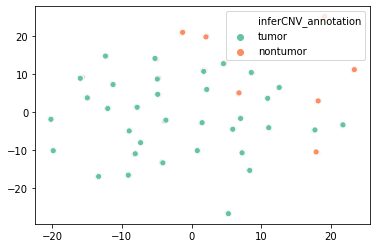

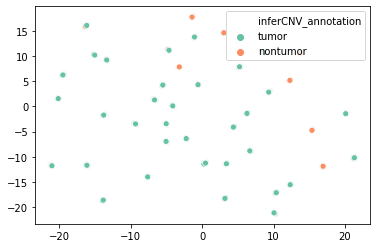

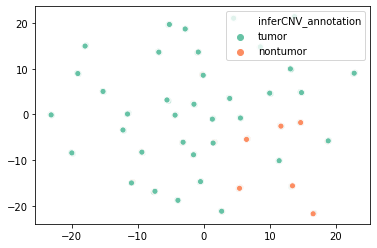

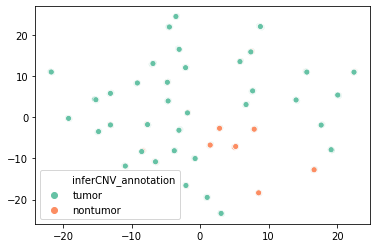

In [9]:
ksizes = 21, 27
molecules = 'DNA', 'protein', 'dayhoff'
ignore_abundances = True, False

folder = '/home/olga/pureScratch/kmer-hashing/lung_adenocarcinoma/nf-kmer-similarity/sketches/'

for ksize, molecule in itertools.product(ksizes, molecules):
    print(f"\n--- ksize: {ksize}, molecule: {molecule} ---")

    sketch_id = f'molecule-{molecule.lower()}_ksize-{ksize}_log2sketchsize-12'
    print(f'sketch_id: {sketch_id}')
    all_signatures = glob.glob(f'{folder}/*{sketch_id}.sig')
    print(f"len(all_signatures): {len(all_signatures)}")
    basenames = [os.path.basename(x) for x in all_signatures]

    annotated_files = list(itertools.chain(*[[x for x in basenames if x.startswith(cell_id)] for cell_id in annotations.index]))
    print(f"len(annotated_files): {len(annotated_files)}")
    annotated_full_path = [folder + x for x in annotated_files]
    print(f"len(annotated_full_path): {len(annotated_full_path)}")
    
    tree = build_sbt(annotated_full_path, ksize=ksize, moltype=molecule)
    print(f"len(tree.nodes): {len(tree.nodes)}")
    cells = [x.data.name() for x in tree.leaves()]
    print(f"len(cells): {len(cells)}")
    annotations_subset = annotations.loc[cells]


    for ignore_abundance in ignore_abundances:
        print(f"\tignore_abundance: {ignore_abundance}")
        umapper = umap.UMAP(n_neighbors=n_neighbors, ignore_abundance=ignore_abundance)

        embedding = umapper.fit_transform(tree)

        print(embedding.shape)

        fig, ax = plt.subplots(figsize=(6, 4))

        x = embedding[:, 0]
        y = embedding[:, 1]
        sns.scatterplot(x, y, hue=annotations_subset['inferCNV_annotation'], palette='Set2')

In [10]:
embedding.shape

(675, 2)

In [15]:
len(tree.nodes)

0

## Do graph embedding